# NBA Fantasy Points Optimisation - ANSH TANDON

## Answering Luka's Data Science Question

### Coming up with the question: Negotiation

After speaking with Luka (and multiple renegotiations), we finally arrived on an interesting data science project about NBA Fantasy Optimisation due to his passion for basketball. He is an avid player of the fantasy game and wanted some insights on how he could take his team to the next level.

From our initial text conversation, Luka posed the following question:
*"Does there exist a player archetype/playstyle that produces maximal fantasy points for a season in comparison to other archetypes/playstyles?"*

To figure out what it would take for Luka to be satisfied with his question, I had to figure out what the question actually meant. Hence I asked him the following:
(1) *"when you refer to archetype - do you mean position (e.g., PG, SG, C)?"*
(2) *"what would it take for you to be satisfied with your question?"*
(3) *"what are the sub-problems involved?"*

Luka informed me that by general archetypes he meant meant more along the lines of three-point specialists or traditional big men, etc. but also recognised that it may be difficult to figure out the definition for each playstyle. Thus, he said that it would be acceptable to stick to position.

In regards to the final result he had in mind, Luka said that he'd be satisfied by this question if he got a good metric or visualisation that helps rank positions in terms of worth in fantasy basketball.

### First obstacle to jump before starting the analysis

The initial hurdle that I had to overcome was understanding how the NBA Fantasy points scoring system actually works. It was all well and good having the metrics out in front of me in the dataset, but I needed to determine a weighting system to assign certain metrics with greater value than others. To do this I used the ESPN website and came up with the following system:

Point = 1

3PM = 1

FGA = -1

FGM = 2

FTA = -1

FTM = 1

REB = 1

AST = 2

STL = 4

BLK = 4

TOV = -2

### How can I figure out what an archetype actually is?

I really wanted the project to satisfy Luka's curiousity so I took it on myself to try and come up with a way of analysing player archetypes. To do so, I had to first research what types of ones were out there. The two following websites helped me gauge an idea:

(1) https://rotogrinders.com/pages/nba-defense-vs-archetype-overview-2703460

(2) https://2kleague.nba.com/official-archetype-info/

Now, once I came to an understanding as to the different archetypes players can come under, I had to figure out a quantifiable way of categorising them. For example, how do I know if Player X is a passer and not a sharpshooter.

Anthropic's Claude LLM aided me here. I fed it with the metrics in my dataset to come up with different playstyles. After multiple iterations and tweaks, I came up with the following criteria: 

*Sharpshooter* - 3P% > 70%

*Rebounder* - REB > 700

*Passer* - AST > 400, TOV < 10

*Defensive Specialist* - STL > 150, BLK > 100

*Efficient Scorer* - FG% > 48%, 3P% > 40%

*Stretch Big* - C or PF, 3P% > 35%, 3PA > 100

*Paint Protector* - C or PF, BLK > 90, REB > 250

*3 and D Wing* - G or F, 3P% > 35%, STL > 100

*Swiss Army Knife* - AST > 200, REB > 200, STL > 80

## Here goes with the analysis...

### Load the dataset

In [11]:
import pandas as pd

# Load the dataset
df = pd.read_csv('2023_nba_player_stats.csv')

# Display the first few rows of the dataset
print(df.head())

                     PName POS Team  Age  GP   W   L     Min   PTS  FGM  ...  \
0             Jayson Tatum  SF  BOS   25  74  52  22  2732.2  2225  727  ...   
1              Joel Embiid   C  PHI   29  66  43  23  2284.1  2183  728  ...   
2              Luka Doncic  PG  DAL   24  66  33  33  2390.5  2138  719  ...   
3  Shai Gilgeous-Alexander  PG  OKC   24  68  33  35  2416.0  2135  704  ...   
4    Giannis Antetokounmpo  PF  MIL   28  63  47  16  2023.6  1959  707  ...   

   REB  AST  TOV  STL  BLK   PF    FP  DD2  TD3  +/-  
0  649  342  213   78   51  160  3691   31    1  470  
1  670  274  226   66  112  205  3706   39    1  424  
2  569  529  236   90   33  166  3747   36   10  128  
3  329  371  192  112   65  192  3425    3    0  149  
4  742  359  246   52   51  197  3451   46    6  341  

[5 rows x 30 columns]


In [12]:
# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())

PName    0
POS      5
Team     0
Age      0
GP       0
W        0
L        0
Min      0
PTS      0
FGM      0
FGA      0
FG%      0
3PM      0
3PA      0
3P%      0
FTM      0
FTA      0
FT%      0
OREB     0
DREB     0
REB      0
AST      0
TOV      0
STL      0
BLK      0
PF       0
FP       0
DD2      0
TD3      0
+/-      0
dtype: int64
              Age          GP           W           L          Min  \
count  539.000000  539.000000  539.000000  539.000000   539.000000   
mean    25.970315   48.040816   24.018553   24.022263  1103.617625   
std      4.315513   24.650686   14.496366   13.445866   827.765114   
min     19.000000    1.000000    0.000000    0.000000     1.000000   
25%     23.000000   30.500000   12.000000   14.000000   329.000000   
50%     25.000000   54.000000   25.000000   25.000000   970.200000   
75%     29.000000   68.000000   36.000000   34.000000  1845.900000   
max     42.000000   83.000000   57.000000   60.000000  2963.200000   

               PTS        

### Calculating Fantasy Points

In [13]:
# Define the fantasy scoring system based on the ESPN source
fantasy_points = (
    df['PTS'] + df['3PM'] + 2 * df['FGM'] - df['FGA'] - df['FTA'] +
    df['FTM'] + df['REB'] + 2 * df['AST'] + 4 * df['STL'] +
    4 * df['BLK'] - 2 * df['TOV']
)

# Add the fantasy points column to the dataframe
df['FP'] = fantasy_points

Now, the dataframe df contains a new column 'FP' representing the fantasy points for each player.

### Analyse Positions

In [14]:
import matplotlib.pyplot as plt

# Group by position and calculate the average fantasy points
average_fp_by_position = df.groupby('POS')['FP'].mean().sort_values(ascending=False)

### Plotting the Graph

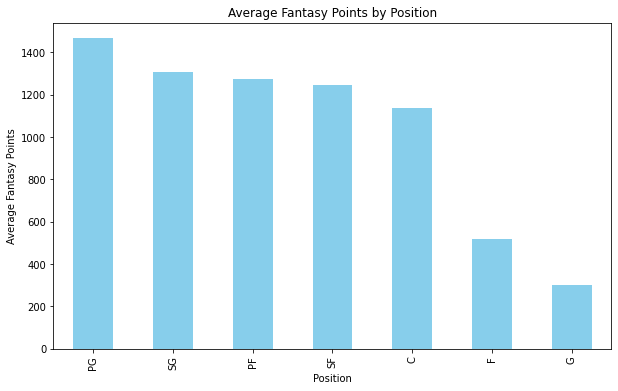

In [15]:
# Plot the results for average fantasy points by position
plt.figure(figsize=(10, 6))
average_fp_by_position.plot(kind='bar', color='skyblue')
plt.title('Average Fantasy Points by Position')
plt.xlabel('Position')
plt.ylabel('Average Fantasy Points')
plt.show()

### Determine the position with the most fantasy points

In [16]:
max_position = average_fp_by_position.idxmax()
print(f'The player position that resulted in the most fantasy points for the season is: {max_position}')

The player position that resulted in the most fantasy points for the season is: PG


### Categorising players into archetypes

In [17]:
# Function to categorise players based on archetypes
def categorize_player(row):
    if row['3P%'] > 70:
        return 'Sharpshooter'
    elif row['REB'] > 700:
        return 'Rebounder'
    elif row['AST'] > 400 and row['TOV'] < 10:
        return 'Passer'
    elif row['STL'] > 150 and row['BLK'] > 100:
        return 'Defensive Specialist'
    elif row['FG%'] > 48 and row['3P%'] > 40:
        return 'Efficient Scorer'
    elif (row['POS'] in ['C', 'PF']) and row['3P%'] > 35 and row['3PA'] > 100:
        return 'Stretch Big'
    elif (row['POS'] in ['C', 'PF']) and row['BLK'] > 90 and row['REB'] > 250:
        return 'Paint Protector'
    elif (row['POS'] in ['G', 'F']) and row['3P%'] > 35 and row['STL'] > 100:
        return '3 and D Wing'
    elif row['AST'] > 200 and row['REB'] > 200 and row['STL'] > 80:
        return 'Swiss Army Knife'
    else:
        return 'Other'

# Apply the function to create a new column 'Archetype'
df['Archetype'] = df.apply(categorize_player, axis=1)

### Archetype Analysis

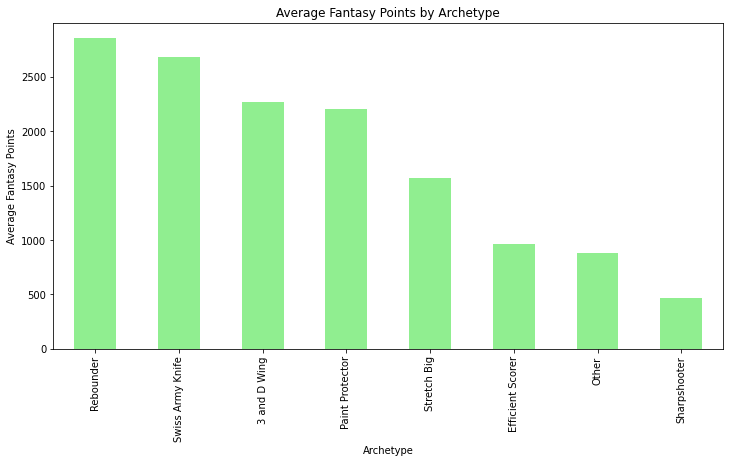

In [18]:
# Group by archetype and calculate the average fantasy points
average_fp_by_archetype = df.groupby('Archetype')['FP'].mean().sort_values(ascending=False)

# Plot the results for average fantasy points by archetype
plt.figure(figsize=(12, 6))
average_fp_by_archetype.plot(kind='bar', color='lightgreen')
plt.title('Average Fantasy Points by Archetype')
plt.xlabel('Archetype')
plt.ylabel('Average Fantasy Points')
plt.show()

### Determine the archetypes with the most fantasy points

In [19]:
top_three_archetypes = average_fp_by_archetype.nlargest(3).index
print(f'The top three archetypes that resulted in the most fantasy points for the season are: {", ".join(top_three_archetypes)}')

The top three archetypes that resulted in the most fantasy points for the season are: Rebounder, Swiss Army Knife, 3 and D Wing


## Answering the intial question

The analysis reveals interesting insights into fantasy basketball performance for the 2023 season.

### Top Position: 

The player position that resulted in the most fantasy points for the season is *Point Guard* (PG). PGs demonstrated a consistent ability to contribute across various statistical categories, leading to higher fantasy point production compared to other positions.

### Top Three Archetypes:

*Rebounder*: Players classified as Rebounders excelled in accumulating rebounds, with an emphasis on both offensive and defensive boards. This archetype showcased a strong presence in the paint and contributed significantly to fantasy points through rebounding.

*Swiss Army Knife*: The Swiss Army Knife archetype demonstrated versatility on the court, contributing not only in scoring but also in rebounding, assists, and steals. Players fitting this archetype displayed an all-around skill set, making them valuable assets for fantasy basketball teams.

*3 and D Wing*: The 3 and D Wing archetype, consisting of guards or forwards with a focus on three-point shooting and defensive contributions, proved to be highly effective. These players demonstrated proficiency in both long-range shooting and defensive skills, resulting in a well-rounded fantasy performance.

## Why did we obtain these results?

PG Dominance: Point Guards are often the primary playmakers on the court, contributing significantly to points, assists, and steals. Their involvement in various facets of the game makes them a valuable fantasy asset.

Rebounder Impact: The Rebounder archetype, with an emphasis on rebounding, likely includes dominant big men who contribute not only in scoring but also in securing possessions through effective rebounding. This archetype's success can be attributed to their ability to control the boards.

Versatility of Swiss Army Knife: The Swiss Army Knife archetype's success is rooted in the versatility of players who can impact multiple statistical categories. Players fitting this archetype can fill various roles on the court, making them valuable contributors in fantasy basketball.

3 and D Wing's All-Around Skills: The 3 and D Wing archetype combines essential skills of three-point shooting and defensive prowess. Players in this category contribute to scoring while also making valuable defensive plays, resulting in a balanced and impactful fantasy performance.

In summary, the top-performing position and archetypes showcase the importance of a well-rounded skill set, including scoring, playmaking, rebounding, and defensive contributions, in achieving success in fantasy basketball. The results highlight the significance of player roles and playing styles in fantasy point production.

## Why did the other archetypes not accumulate as many fantasy points?

The performance disparity among the archetypes can be attributed to the specific criteria defining each playstyle and the inherent challenges associated with meeting those criteria consistently throughout the season.

Sharpshooter (3P% > 70%): Achieving a three-point shooting percentage consistently above 70% is an extraordinary feat and may be difficult for players to maintain over the course of an entire season. The limited number of players meeting this exceptional criterion could result in fewer fantasy points.

Passer (AST > 400, TOV < 10): Players falling under the Passer archetype need to accumulate a substantial number of assists (AST) while minimising turnovers (TOV). Meeting both criteria consistently requires a delicate balance and might be challenging for players, affecting their overall fantasy point production.

Defensive Specialist (STL > 150, BLK > 100): The Defensive Specialist archetype demands both high steal (STL) and block (BLK) numbers. While some players excel in one defensive aspect, maintaining high counts in both categories can be challenging. Limited players meeting both criteria might result in lower representation and fantasy points.

Efficient Scorer (FG% > 48%, 3P% > 40%): This archetype necessitates a high field goal percentage (FG%) and three-point percentage (3P%). Consistently achieving both efficient scoring metrics may be challenging for players, impacting their overall fantasy point contribution.

Stretch Big (C or PF, 3P% > 35%, 3PA > 100): Centers (C) or power forwards (PF) fitting the Stretch Big archetype must excel in three-point shooting with a minimum number of attempts. Limited players meeting these criteria may result in fewer fantasy points compared to archetypes with broader applicability.

Paint Protector (C or PF, BLK > 90, REB > 250): Similar to Stretch Big, the Paint Protector archetype demands specific criteria for centers and power forwards, including high block numbers and rebound counts. Fewer players meeting these stringent conditions could lead to lower fantasy point production.

While the top-performing archetypes like Rebounder, Swiss Army Knife, and 3 and D Wing demonstrated versatility and consistency across multiple criteria, the other archetypes presented challenges in meeting specific and often demanding conditions, limiting their representation and subsequent fantasy point accumulation.

## Reflection on use of LLMs

In this data science project, LLMs (specifically Claude and GPT 4) was used to as an aid rather than a go-to. For example, I used the LLMs to help me figure out weights for the metrics involved in player archetypes. However, thorough inspection of the outputs were required because there were nuances in the answers that the LLMs did not fully comprehend. One scenario was figuring out the 3 point percentage for a sharpshooter. I had to manually override the LLM response and set the 3P% > 70 because otherwise it would be too low - thus making a lot of players sharpshooters.

At the start of the semester, I tended to view LLM response as *'correct'*, giving their responses more weight than they deserved, without thoroughly evaluating or questioning them. I've since learned not to do that. I now approach LLMs with increased confidence when brainstorming ideas and initiating projects, making sure to rigourously understand the logic before executing code.

In [20]:
!jupyter nbconvert --to html "/Users/anshtandon/Desktop/NBA_Fantasy.ipynb"

[NbConvertApp] Converting notebook /Users/anshtandon/Desktop/NBA_Fantasy.ipynb to html
[NbConvertApp] Writing 348546 bytes to /Users/anshtandon/Desktop/NBA_Fantasy.html
